In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm.notebook import trange, tqdm
from itertools import product
import pickle

## Oracle Impurity Score (OIS)

In [2]:
# Binary Classifier Module
class MLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: tuple[int, ...] = (32,)):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU(inplace=True))
            prev_dim = h
        layers.append(nn.Linear(prev_dim, 1))  # single-logit output
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # returns logits
        return self.net(x).squeeze(-1)
    
def train_binary_classifier(
    model: nn.Module,
    x_train: torch.Tensor,
    y_train: torch.Tensor,
    device: str = 'cpu',
    epochs: int = 25,
    batch_size: int = 128,
    lr: float = 1e-3
) -> None:
    """Train `model` to predict y_train from x_train using BCEWithLogitsLoss."""
    model.to(device)
    model.train()
    dataset = TensorDataset(x_train, y_train)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    for _ in range(epochs):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [5]:
# Purity Matrix
def purity_matrix(
    reprs_train: torch.Tensor,
    labels_train: torch.Tensor,
    reprs_test:  torch.Tensor,
    labels_test:  torch.Tensor,
    hidden_dims: tuple[int, ...] = (32,),
    epochs: int = 25,
    batch_size: int = 128,
    lr: float = 1e-3,
    device: str = 'cpu'
) -> torch.Tensor:
    """
    Returns a (k x k) purity matrix, where k = number of concepts.
    reprs_*: shape (n_samples, k, repr_dim)
    labels_*: shape (n_samples, k), values in {0,1}
    """

    _, k, d = reprs_train.shape
    M = torch.zeros(k, k, dtype=torch.float32)

    for i, j in tqdm(
        product(range(k), range(k)),
        total=k * k,
        desc="Computing Purity Matrix",
        leave=False
    ):
        # unpack features and labels
        x_tr = reprs_train[:, i, :]    # (n, d)
        x_te = reprs_test[:,  i, :]
        y_tr = labels_train[:, j]      # (n,)
        y_te = labels_test[:,  j]

        # train psi_{i,j}
        net = MLP(input_dim=d, hidden_dims=hidden_dims)
        train_binary_classifier(net, x_tr, y_tr, device, epochs, batch_size, lr)

        # get predicted probabilities on test set
        net.eval()
        with torch.no_grad():
            logits = net(x_te.to(device))
            probs  = torch.sigmoid(logits).cpu().numpy()
            auc = roc_auc_score(y_te.cpu().numpy(), probs)
            
        M[i, j] = auc

    return M

def oracle_impurity_score(
    cavs: torch.Tensor,
    data: torch.Tensor,
    labels: torch.Tensor,
    hidden_dims:  tuple[int, ...] = (32,),
    epochs: int = 25,
    batch_size: int = 128,
    lr: float = 1e-3,
    test_size: float = 0.2,
    device: str = 'cpu',
    random_seed : int = 23
) -> float:
    """
    Compute OIS = (2/k) * || M_hat - M_oracle ||_F.
    Returns a float in [0,1].
    """
    # 0) Compute per-sample representations via Hadamard product
    data = data.to(cavs.device)
    reprs = data.unsqueeze(1) * cavs.unsqueeze(0)

    # 1) Split into train/test
    r_tr, r_te, y_tr, y_te = train_test_split(
        reprs, labels, test_size=test_size,
        random_state=random_seed
    )
    
    # 2) learnt‐concept purity matrix
    M_hat = purity_matrix(
        r_tr, y_tr,
        r_te,  y_te,
        hidden_dims, epochs, batch_size, lr, device
    )
    # 3) oracle purity matrix: predict j from i using labels directly
    k = y_tr.shape[1]
    M_oracle = torch.zeros(k, k)
    for i in range(k):
        for j in range(k):
            M_oracle[i,j] = roc_auc_score(
                y_te[:,j].cpu().numpy(),
                y_te[:,i].cpu().numpy()
            )

    # 4) Frobenius‐norm difference
    diff = M_hat - M_oracle
    fro = torch.norm(diff, p='fro').item()

    # 5) scale to [0,1]
    return (2.0 / k) * fro

### Results

In [121]:
latents = torch.load('variables/latents_diffae.pt', weights_only=True)
labels = torch.load('variables/labels_diffae.pt', weights_only=True)
with open('variables/concept_names.pkl', 'rb') as f:
    concept_names = pickle.load(f)

torch.manual_seed(42)
perm = torch.randperm(latents.size(0))[:20000]
latents = latents[perm]
labels = labels[perm]

latents.shape

torch.Size([20000, 512])

In [34]:
scavs = torch.load('checkpoints/scav_vgg16_celeba.pth', weights_only=True)
scavs = scavs['weights'].squeeze(0)

ois = oracle_impurity_score(scavs, latents, labels, device='mps')
print(f'OIS: {ois}')

Computing Purity Matrix:   0%|          | 0/1600 [00:00<?, ?it/s]

OIS: 0.6010709285736084


In [19]:
scavs = torch.load('results/cavs-signal:alpha0.1_lr0.001/cavs.pt', weights_only=True)

ois = oracle_impurity_score(scavs, latents, labels, device='mps')
print(f'OIS: {ois}')

Computing Purity Matrix:   0%|          | 0/1600 [00:00<?, ?it/s]

OIS: 0.5953507423400879


In [28]:
lcavs = torch.load('results/cavs-linear:alpha0_lr0.1/cavs.pt', weights_only=True)

ois = oracle_impurity_score(lcavs, latents, labels, device='mps')
print(f'OIS: {ois}')

Computing Purity Matrix:   0%|          | 0/1600 [00:00<?, ?it/s]

OIS: 0.5921317100524902


## CAV Impurity Score

In [4]:
# CAV Purity Matrix
def cav_purity_matrix(
    cavs: torch.Tensor,
    latents: torch.Tensor,
    labels: torch.Tensor,
    device: str = 'cpu'
) -> torch.Tensor:
    """
    Returns a (n_concepts x n_concepts) CAV purity matrix.
    cavs: shape (n_concepts, n_dim)
    latents: shape (n_samples, n_dim)
    labels: shape (n_samples, n_concepts), values in {0,1}
    """

    n_concepts, _ = cavs.shape
    M = torch.zeros(n_concepts, n_concepts, dtype=torch.float32, device=device)

    # Project on to CAVs
    logits = latents.to(device) @ cavs.to(device).T

    # Compute AUC for each CAV-concept pair
    for i, j in tqdm(
        product(range(n_concepts), range(n_concepts)),
        total=n_concepts * n_concepts,
        desc="Computing Purity Matrix",
        leave=False
    ):
        scores = logits[:, i].detach().cpu().numpy()
        y_true = labels[:, j].cpu().numpy()
        auc = roc_auc_score(y_true, scores)
        M[i,j] = auc

    return M

In [68]:
def label_roc_auc_matrix(
    labels: torch.Tensor,
    device: str = 'cpu'
) -> torch.Tensor:
    """
    Returns a (n_concepts x n_concepts) matrix M where
    M[i,j] = ROC-AUC of using label i (as predictor) to predict label j.
    
    labels:   shape (n_samples, n_concepts), binary {0,1}
    device:   where to allocate the result
    """
    N, C = labels.shape
    M = torch.zeros(C, C, dtype=torch.float32, device=device)
    # cast labels[:,i] to float as scores
    scores = labels.float()
    
    for i, j in tqdm(
        product(range(C), range(C)),
        total=C * C,
        desc="Computing Label ROC-AUC Matrix",
        leave=False
    ):
        s_i = scores[:, i].cpu().numpy()
        y_j = labels[:, j].cpu().numpy()
        auc = roc_auc_score(y_j, s_i)
        M[i, j] = auc
    
    return M


def label_conditional_probability_matrix(
    labels: torch.Tensor,
    device: str = 'cpu'
) -> torch.Tensor:
    """
    Returns a (n_concepts x n_concepts) matrix P where
    P[i,j] = P(j=1 | i=1) = 
      (# samples with i=1 and j=1) / (# samples with i=1).
    
    labels: shape (N, C), binary {0,1}
    """
    N, C = labels.shape
    P = torch.zeros(C, C, dtype=torch.float32, device=device)
    
    for i, j in tqdm(
        product(range(C), range(C)),
        total=C * C,
        desc="Computing Label Conditional Probablity Matrix",
        leave=False
    ):
        mask_i = labels[:, i] == 1
        count_i = mask_i.sum().item()
        P[i, j] = labels[mask_i, j].sum().float() / count_i
    
    return P

def label_correlation_matrix(
    labels: torch.Tensor,
    device: str = 'cpu'
) -> torch.Tensor:
    """
    Returns a (n_concepts x n_concepts) matrix phi where
    phi[i,j] = Pearson correlation of the two binary vectors labels[:,i] and labels[:,j].
    
    This is also known as the phi‐coefficient for binary variables.
    """
    N, C = labels.shape
    L = labels.float()
    phi = torch.zeros(C, C, dtype=torch.float32, device=device)
    
    # precompute means and variances
    means = L.mean(dim=0)               # shape (C,)
    variances = ((L - means)**2).mean(dim=0)  # shape (C,)
    
    for i in range(C):
        xi = L[:, i] - means[i]
        vi = variances[i]
        for j in range(C):
            xj = L[:, j] - means[j]
            vj = variances[j]
            if vi == 0 or vj == 0:
                phi[i, j] = float('nan')
            else:
                cov = (xi * xj).mean()
                phi[i, j] = cov / torch.sqrt(vi * vj)
    
    return phi

In [58]:
def cav_purity_score(
    cavs: torch.Tensor,
    data: torch.Tensor,
    labels: torch.Tensor,
    # oracle: str = 'label',
    device: str = 'cpu',
) -> float:
    """
    Compute OIS = (2/k) * || M_hat - M_oracle ||_F.
    Returns a float in [0,1].
    """

    # oracle_method = {
    #     'label': label_roc_auc_matrix,
    #     'prob': label_conditional_probability_matrix,
    #     'corr': label_correlation_matrix
    # }

    # Compute CAV Purity Matrix
    M_hat = cav_purity_matrix(cavs, data, labels, device=device)
    
    # Compute Oracle Purity Matrix
    M_oracle = label_roc_auc_matrix(labels, device=device)

    # 4) Frobenius‐norm difference
    fro = torch.norm(M_hat - M_oracle.abs(), p='fro').item()

    # 5) scale to [0,1]
    return 1 - (2.0 / cavs.shape[0]) * fro

### Debug

Computing Purity Matrix:   0%|          | 0/1600 [00:00<?, ?it/s]

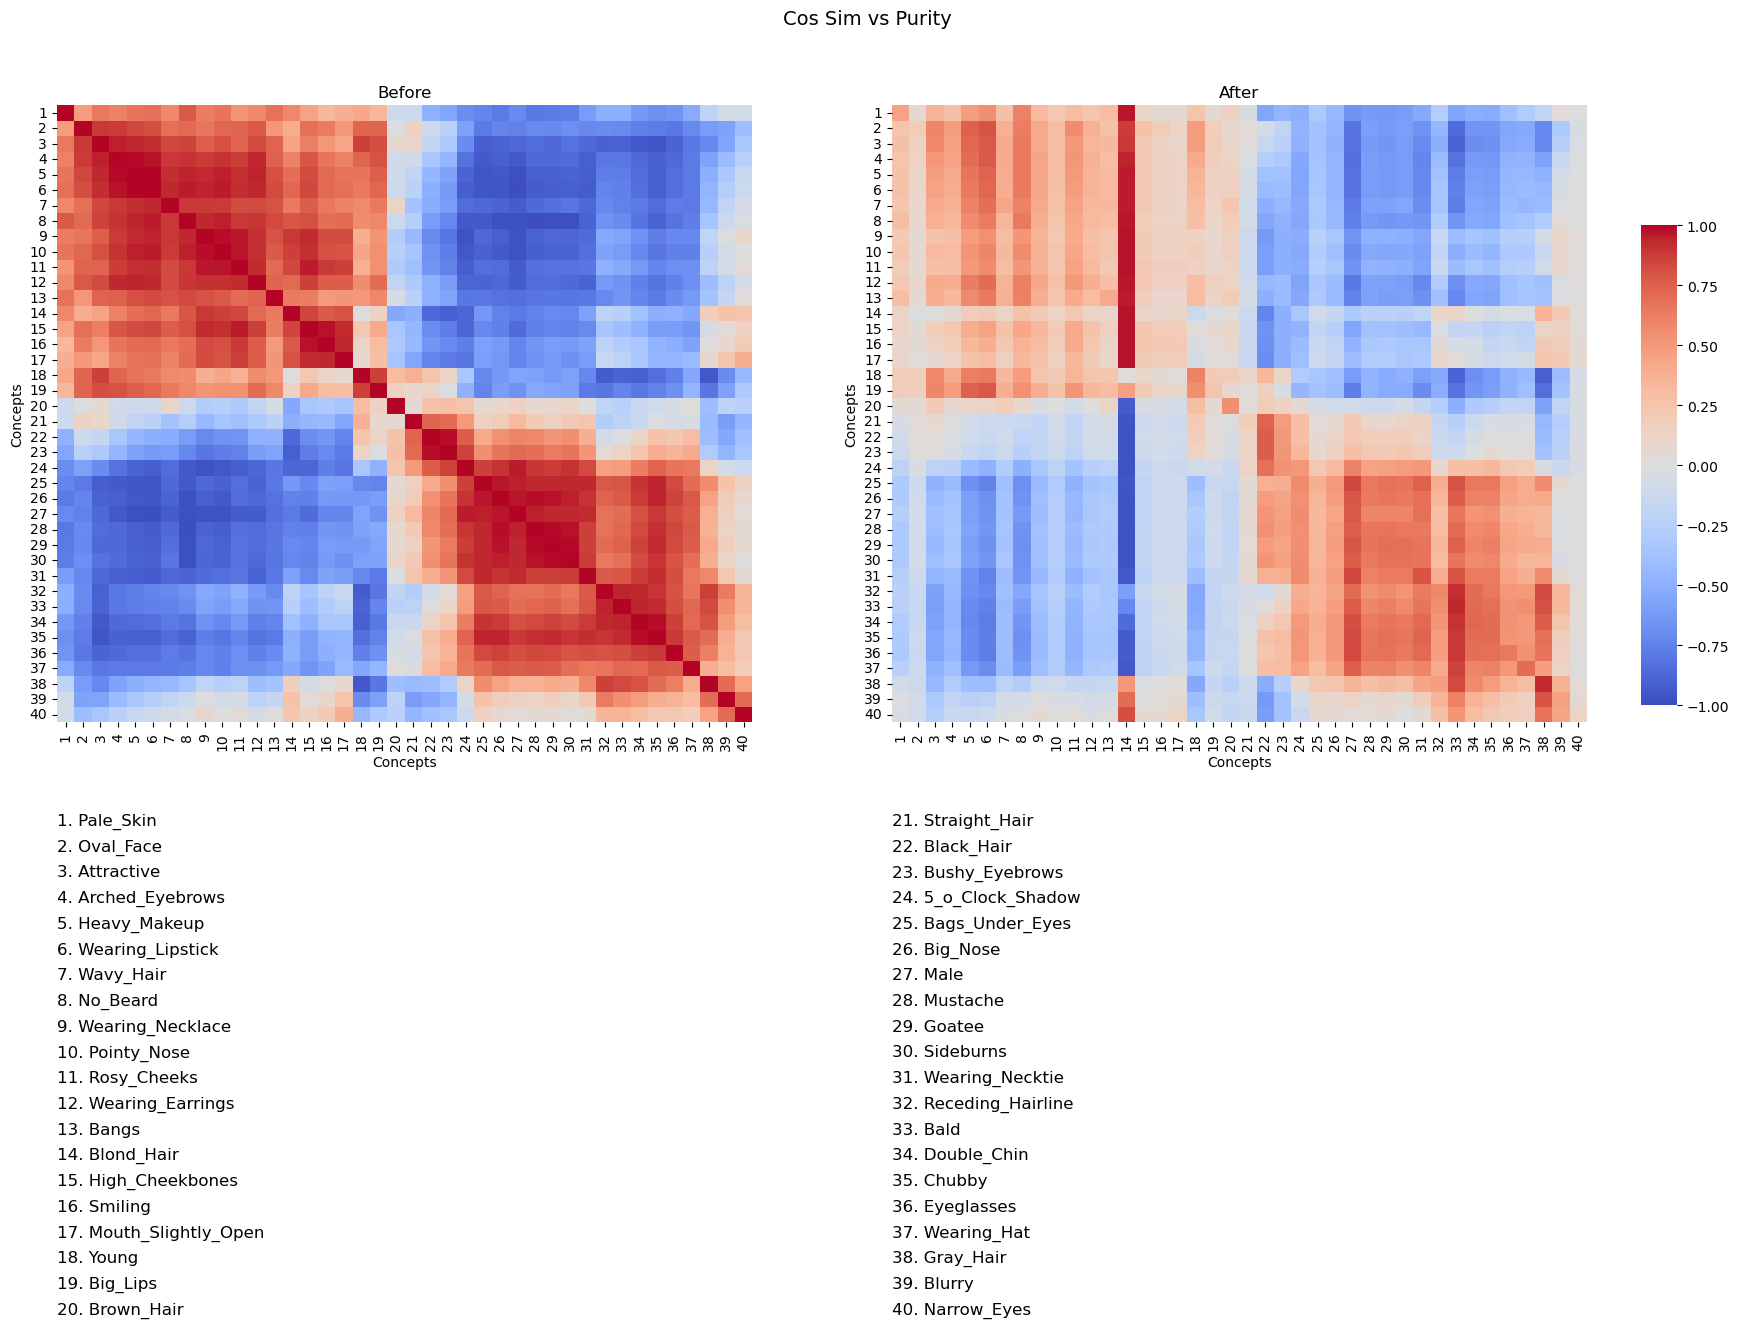

In [46]:
from utils.sim_matrix import visualize_before_after_sim_matrices, visualize_sim_matrix, reorder_similarity_matrix

latents = torch.load('variables/latents_celeba_vgg16.pt', weights_only=True)
labels = torch.load('variables/labels.pt', weights_only=True)
with open('variables/concept_names.pkl', 'rb') as f:
    concept_names = pickle.load(f)

scavs = torch.load('checkpoints/scav_vgg16_celeba.pth', weights_only=True)
scavs = scavs['weights'].squeeze(0)

M = cav_purity_matrix(scavs, latents, labels, device='mps')

visualize_before_after_sim_matrices(scavs @ scavs.T, M*2 -1, concept_names, title='Cos Sim vs Purity')

Computing Label ROC-AUC Matrix:   0%|          | 0/1600 [00:00<?, ?it/s]

Computing Label Conditional Probablity Matrix:   0%|          | 0/1600 [00:00<?, ?it/s]

Computing Label Correlation Matrix:   0%|          | 0/1600 [00:00<?, ?it/s]

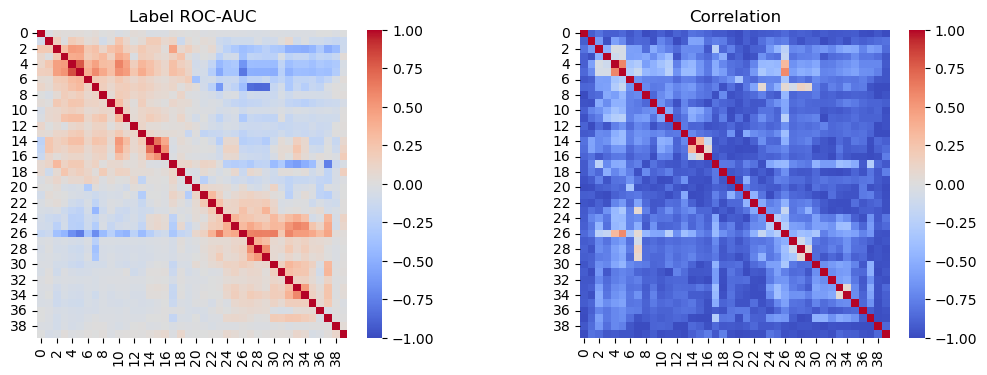

In [52]:
label_M = label_roc_auc_matrix(labels)
prob_M = label_conditional_probability_matrix(labels)
corr_M = label_correlation_matrix(labels)

_, order = reorder_similarity_matrix((scavs @ scavs.T).cpu().numpy())

# Create a 1×3 grid of axes
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plt.subplots_adjust(wspace=0.4)

# Pair each matrix (scaled to [–1,1]) with its title
matrices = [label_M * 2 - 1,
            # prob_M  * 2 - 1,
            corr_M.abs() * 2 - 1]
titles   = ['Label ROC-AUC', 'Correlation']

# Plot each on its own axis
for ax, M, title in zip(axes, matrices, titles):
    plt.sca(ax)  # set this subplot as current
    
    # Visualize
    M_ordered = M[order, :][:, order]
    sns.heatmap(M_ordered, annot=False, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
    plt.title(title)
    plt.xticks(rotation=90)

# Finally, render the combined figure
plt.show()

### Results

In [36]:
latents = torch.load('variables/latents_celeba_vgg16.pt', weights_only=True)
labels = torch.load('variables/labels.pt', weights_only=True)
with open('variables/concept_names.pkl', 'rb') as f:
    concept_names = pickle.load(f)

In [ ]:
scavs = torch.load('checkpoints/scav_vgg16_celeba.pth', weights_only=True)
scavs = scavs['weights'].squeeze(0)

cps = cav_purity_score(scavs, latents, labels, device='mps')
print(f'CPS: {cps}')

Computing Purity Matrix:   0%|          | 0/1600 [00:00<?, ?it/s]

Computing Label ROC-AUC Matrix:   0%|          | 0/1600 [00:00<?, ?it/s]

CPS: 0.677904462814331


In [ ]:
scavs = torch.load('results/cavs-signal:alpha0.1_lr0.001/cavs.pt', weights_only=True)

cps = cav_purity_score(scavs, latents, labels, device='mps')
print(f'CPS: {cps}')

Computing Purity Matrix:   0%|          | 0/1600 [00:00<?, ?it/s]

Computing Label ROC-AUC Matrix:   0%|          | 0/1600 [00:00<?, ?it/s]

CPS: 0.7968722581863403


In [ ]:
lcavs = torch.load('results/cavs-linear:alpha0_lr0.1/cavs.pt', weights_only=True)

cps = cav_purity_score(lcavs, latents, labels, device='mps')
print(f'CPS: {cps}')

Computing Purity Matrix:   0%|          | 0/1600 [00:00<?, ?it/s]

Computing Label ROC-AUC Matrix:   0%|          | 0/1600 [00:00<?, ?it/s]

CPS: 0.7129063129425048


In [44]:
lcavs = torch.load('results/cavs-linear:alpha10_lr0.1/cavs.pt', weights_only=True)

cps = cav_purity_score(lcavs, latents, labels, device='mps')
print(f'CPS: {cps}')

Computing Purity Matrix:   0%|          | 0/1600 [00:00<?, ?it/s]

Computing Label ROC-AUC Matrix:   0%|          | 0/1600 [00:00<?, ?it/s]

CPS: 0.8535294532775879


## Niche Purity Score

In [115]:
def get_concept_niches(
    labels: torch.Tensor,
    beta: float,
    device: str = 'cpu'
) -> list:
    _, C = labels.shape

    # Compute the absolute correlation matrix
    PHI = label_correlation_matrix(labels, device=device).abs()
    
    # Obtain concept niches
    mask = PHI > beta
    concept_niches = [torch.where(mask[i])[0].tolist() for i in range(C)]

    return concept_niches


def compute_niche_impurities(
    cavs: torch.Tensor,
    latents: torch.Tensor,
    labels: torch.Tensor,
    beta: float,
    device: str = 'cpu',
) -> torch.Tensor:
    C, _ = cavs.shape
    
    # Obtain the concept niches
    concept_niches = get_concept_niches(labels, beta, device=device)

    # Compute Niche Purities Per Concept Label
    niche_purities = torch.zeros((C, ))
    for i, niche in enumerate(concept_niches):
        # Handle empty niche (expected for higher values of beta)
        if niche == []:
            niche_purities[i] = 0
            continue
        # Compute niche purity score
        concept_niche = torch.tensor(niche, device=device)
        cavs_niche = torch.index_select(cavs, 0, concept_niche)
        logits_niche = latents.to(device) @ cavs_niche.to(device).T
        scores = logits_niche.mean(dim=1).cpu().numpy()
        y_true = labels[:, i].cpu().numpy()
        auc = roc_auc_score(y_true, scores)
        niche_purities[i] = auc

    return niche_purities


In [102]:
def niche_impurity_score(
    cavs: torch.Tensor,
    latents: torch.Tensor,
    labels: torch.Tensor,
    n_steps: int = 100,
    per_concept: bool = False,
    device: str = 'cpu',
) -> torch.Tensor | float:
    """
    Returns a score in range [0,1] that is the 
    ∫ avg(purity(Beta))dBeta, approximated via the trapezoid rule
    on `n_steps` equally-spaced beta values.
    """
    # Build a beta‐grid in [0,1]
    betas = torch.linspace(0.0, 1.0, steps=n_steps, device=device) 

    # Compute purity curves: shape (C, n_steps)
    purity_curve = []
    for beta in tqdm(betas, desc="Integrating over Betas"):
        niche_purity = compute_niche_impurities(cavs.to(device), latents, labels, beta.item(), device=device)
        purity_curve.append(niche_purity)
        
    purity_curve = torch.stack(purity_curve, dim=1).to(device)

    # Trapezoidal integration along dim=1
    nps = torch.trapz(purity_curve, betas, dim=1)  # (C,)

    if per_concept:
        return nps
    else:
        return nps.mean().item()

In [116]:
scavs = torch.load('checkpoints/scav_vgg16_celeba.pth', weights_only=True)
scavs = scavs['weights'].squeeze(0)

nis_scavs = niche_impurity_score(scavs, latents, labels, per_concept=True, device='mps')
print(nis_scavs)
print(f"NIS: {nis_scavs.mean()}")

Integrating over Betas:   0%|          | 0/100 [00:00<?, ?it/s]

tensor([0.6348, 0.6988, 0.7176, 0.6652, 0.9515, 0.6772, 0.6120, 0.7194, 0.8576,
        0.9695, 0.6899, 0.7194, 0.7451, 0.8298, 0.8345, 0.7400, 0.7987, 0.8768,
        0.7974, 0.6175, 0.3683, 0.5955, 0.8040, 0.5569, 0.5454, 0.5820, 0.7079,
        0.6169, 0.7752, 0.7279, 0.7856, 0.5996, 0.5792, 0.6903, 0.6812, 0.7674,
        0.8241, 0.6805, 0.8472, 0.6447], device='mps:0')
NIS: 0.7133166193962097


In [117]:
scavs_opt = torch.load('results/cavs-signal:alpha0.1_lr0.001/cavs.pt', weights_only=True)

nis_scavs_opt = niche_impurity_score(scavs_opt, latents, labels, per_concept=True, device='mps')
print(nis_scavs_opt)
print(f"NIS: {nis_scavs_opt.mean()}")

Integrating over Betas:   0%|          | 0/100 [00:00<?, ?it/s]

tensor([0.6870, 0.7141, 0.7268, 0.6913, 0.9476, 0.7955, 0.6369, 0.7096, 0.8489,
        0.9112, 0.7507, 0.7869, 0.7497, 0.8316, 0.8407, 0.8507, 0.8027, 0.8754,
        0.7722, 0.6681, 0.4538, 0.6548, 0.8009, 0.6295, 0.5355, 0.6482, 0.8210,
        0.6252, 0.7895, 0.7516, 0.8039, 0.6858, 0.6404, 0.7069, 0.7039, 0.8776,
        0.7611, 0.6622, 0.8661, 0.6508], device='mps:0')
NIS: 0.7416593432426453


In [118]:
lcavs = torch.load('results/cavs-linear:alpha0_lr0.1/cavs.pt', weights_only=True)

nis_lcavs = niche_impurity_score(lcavs, latents, labels, per_concept=True, device='mps')
print(nis_lcavs)
print(f"NIS: {nis_lcavs.mean()}")

Integrating over Betas:   0%|          | 0/100 [00:00<?, ?it/s]

tensor([0.6336, 0.5680, 0.7360, 0.5052, 0.8921, 0.6831, 0.6006, 0.6285, 0.8649,
        0.7760, 0.6894, 0.7684, 0.7399, 0.7087, 0.7499, 0.7059, 0.6238, 0.7461,
        0.6730, 0.5922, 0.5839, 0.6170, 0.4443, 0.5987, 0.5258, 0.6307, 0.7918,
        0.5622, 0.6680, 0.7563, 0.7058, 0.6323, 0.5764, 0.6880, 0.4860, 0.8477,
        0.6001, 0.6727, 0.8125, 0.7229], device='mps:0')
NIS: 0.6702151298522949


In [119]:
lcavs_opt = torch.load('results/cavs-linear:alpha10_lr0.1/cavs.pt', weights_only=True)

nis_lcavs_opt = niche_impurity_score(lcavs_opt, latents, labels, per_concept=True, device='mps')
print(nis_lcavs_opt)
print(f"NIS: {nis_lcavs_opt.mean()}")

Integrating over Betas:   0%|          | 0/100 [00:00<?, ?it/s]

tensor([0.6539, 0.7375, 0.7760, 0.6578, 0.8891, 0.8396, 0.6435, 0.6808, 0.8401,
        0.9404, 0.7286, 0.7771, 0.7449, 0.7579, 0.7687, 0.7959, 0.6973, 0.7759,
        0.8210, 0.7011, 0.4281, 0.6834, 0.7071, 0.6543, 0.6266, 0.6479, 0.8311,
        0.6472, 0.7631, 0.7850, 0.7115, 0.7181, 0.6490, 0.7441, 0.7155, 0.8522,
        0.8133, 0.6903, 0.8226, 0.7232], device='mps:0')
NIS: 0.7360180020332336


In [112]:
nis_scavs[order[-1]]

tensor(0.5542, device='mps:0')